In [1]:
import keras.utils
import tensorflow as tf
from keras import datasets, layers, models
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

try:
    from classification_models.tfkeras import Classifiers
except:
    !pip install git+https://github.com/qubvel/classification_models.git
    from classification_models.tfkeras import Classifiers

np.random.seed(0)

In [2]:
data_path = "../input/biomassdata/"
train_features_path = f"{data_path}rgb_train_features/"
test_features_path = f"{data_path}rgb_test_features/"
labels_path = f"{data_path}labels/"

In [3]:
def resnet(deep_layers: int,
           input_shape: tuple,
           weights: str = 'imagenet'):
    """
    We want to use a pretrained resnet34 (many other models available from the package we use)
    For our task, we take off the layers responsible for performing the task, but keep the deep convolutional layers
    These are trained on extracting features, which is very useful for our data
    :param deep_layers: Number of deep layers (at least supported: 18, 34, 50, 101, 151)
    :param input_shape: Shape of input data without batch size (should be width, height, 3)
    :param weights: Where to get weights from. Default pretrained imagenets
    :return: Model
    """

    # Load the pretrained model
    loaded_resnet, preprocess_input = Classifiers.get(f'resnet{deep_layers}')

    # Get the Resnet model, provide input shape of our data and specify on what problem it should be pretrained
    base_model = loaded_resnet(input_shape=input_shape, weights=weights, include_top=False)

    # Construct our output layers at the end of the pretrained model
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

    # And specify multiplication with the previous layer instantly
    flatten = tf.keras.layers.Dense(1024, activation='relu')(x)

    # And specify multiplication with the previous layer instantly
    dense = tf.keras.layers.Dense(1024, activation='relu')(flatten)
    
    # Construct the actual output layer
    # We will use a linear layer (which basically does nothing)
    output = tf.keras.layers.Dense(256 * 256, activation='linear')(dense)

    # Construct the model from the pretrained (34) deep layers, and the specified output layers
    model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

    # Compile the model
    # We will use Stochastic Gradient Descent and MAE as loss, since this was the competition  evaluation metric
    model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # You could print the model summary, but it will be very long ;)
#     model.summary()

    return model

In [2]:
class RGBDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, patch_ids, mode="train", batch_size=32):
        """
        Few things to mention:
            - The data generator tells our model how to fetch one batch of training data (in this case from files)
            - Any work that can be done before training, should be done in init, since we want fetching a batch to be fast
            - Therefore, we want all filenames and labels to be determined before training
            - This saves work, because we will be fetching batches multiple times (across epochs)
        """
        self.dir_path = train_features_path if mode == "train" else test_features_path

        # Get all filenames in directory
        self.patches = patch_ids

        # Include batch size as attribute
        self.batch_size = batch_size
        self.mode = mode

    def __len__(self):
        """
        Should return the number of BATCHES the generator can retrieve (partial batch at end counts as well)
        """
        return int(np.ceil(len(self.patches) / float(self.batch_size)))

    def __getitem__(self, idx):
        """
        Tells generator how to retrieve BATCH idx
        """

        # Get filenames for X batch
        batch_patches = self.patches[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_filenames = [self.dir_path + p + '_S2_00.npy' for p in batch_patches]
        
        if self.mode != "test":
            batch_y = np.stack([np.load(labels_path + p + '.npy') for p in batch_patches], axis=0).reshape(
                (len(batch_patches), 256 * 256))

        # concatenating all the months together and then stacking on each other
        batch_x = np.stack([np.stack([np.load(f)[:, :, 2]]*3, axis=-1) for f in batch_filenames], axis=0)

        return batch_x, batch_y if self.mode == "train" else batch_x


In [3]:
df = pd.read_csv("../input/metadata/features_metadata_FzP19JI.csv")
train_test_split = {df['chip_id'][i]: df['split'][i] for i in range(len(df))}

# Divide patches in train and test set
train_patches = [key for key, value in train_test_split.items() if value == "train"]
random.shuffle(train_patches)

train_patches, validation_patches = train_patches[:5000], train_patches[5000:]

test_patches = [key for key, value in train_test_split.items() if value == "test"]

# Create generators
train_generator = RGBDataGenerator(train_patches, batch_size=64)
validation_generator = RGBDataGenerator(validation_patches, batch_size=64)
test_generator = RGBDataGenerator(test_patches, mode="test", batch_size=64)

model = resnet(50, (256, 256, 3))

FileNotFoundError: [Errno 2] No such file or directory: '../input/metadata/features_metadata_FzP19JI.csv'

In [4]:
X, y = train_generator[0]

print(min(y[10]), max(y[10]), np.mean(y[10]))
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].imshow(X[0])
axs[0, 0].set_title('Datapoint 0')

axs[0, 1].imshow(y[0].reshape((256, 256)))
axs[0, 1].set_title('label 0')

axs[1, 0].imshow(X[10])
axs[1, 0].set_title('Datapoint 1')

axs[1, 1].imshow(y[10].reshape((256, 256)))
axs[1, 1].set_title('label 1')

plt.show()

NameError: name 'train_generator' is not defined

In [7]:
model.fit(train_generator, validation_data=validation_generator, epochs=3)

2022-11-18 10:27:09.189727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-11-18 10:27:18.063904: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 281s 3s/step - loss: 5385.7974 - root_mean_squared_error: 73.3880 - val_loss: 151516.2500 - val_root_mean_squared_error: 389.2509
Epoch 2/3
79/79 [==============================] - 84s 1s/step - loss: 5012.3638 - root_mean_squared_error: 70.7980 - val_loss: 1173490.3750 - val_root_mean_squared_error: 1083.2776
Epoch 3/3
79/79 [==============================] - 84s 1s/step - loss: 4945.0439 - root_mean_squared_error: 70.3210 - val_loss: 87255.8984 - val_root_mean_squared_error: 295.3911


In [8]:
# Create submission from model (not very good obviously, but gives an example)
predictions = model.predict(test_generator)


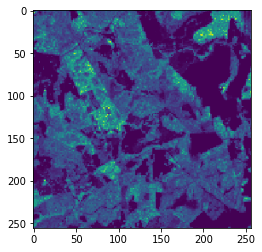

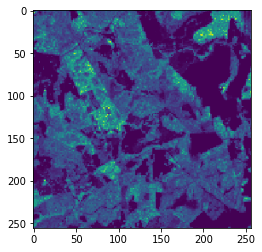

In [9]:
target_shape = (len(predictions), 256, 256)
predictions = predictions.reshape(target_shape)
    
import matplotlib.pyplot as plt    
label = np.load("../input/biomassdata/labels/0040c3a8.npy")
plt.imshow(label)
plt.show()
label = label.flatten()
label = label.reshape((256, 256))
plt.imshow(label)
